In [1007]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')


class GSW_FHE:
    def __init__(self, n, q, l, x, m):
        self.n = n
        self.q = q
        self.x = x
        self.m = m #int(n * np.log2(q))
        print("m: ", self.m)
        self.l = l
        self.N = (self.n + 1) * self.l
    def Powersof2(self, arg):
        two_series = np.ndarray((1, self.l), buffer=np.array([2**x % self.q for x in range(self.l)]), dtype=int)
        res = (arg @ two_series).reshape((-1, 1))
        return res % self.q
    def Flatten(self, A):
        A = A % self.q
        return self.BitDecomp(self.BitDecompInverse(A))
    def BitDecomp(self, A):
        for i in range(A.shape[0]):
            rowA = A[i,:]
            rowBin = np.zeros((1, self.l * A.shape[1]), dtype=int)
            for pos, a_kl in enumerate(rowBin[0]):
                rowBin[0][pos] = int(np.binary_repr(rowA[pos // self.l], width=self.l)[::-1][pos % self.l])
            if (i == 0):
                stored_row = rowBin
            else:
                stored_row = np.append(stored_row, rowBin, axis=0)
        return stored_row
    def BitDecompInverse(self, A):
        def shifting(bitlist):
            out = 0
            for i in range(len(bitlist)):
                out += 2**i * bitlist[i] % self.q
            return out % self.q
            
        for i in range(A.shape[0]):
            rowA = A[i,:]
            rowAm = np.zeros((1, A.shape[1] // self.l), dtype=int)
            for j in range(len(rowAm[0])):
                rowAm[0][j] = shifting(rowA[j * self.l: (j + 1)* self.l]) 
            if (i == 0):
                stored_row = rowAm
            else:
                stored_row = np.append(stored_row, rowAm, axis=0)
        return stored_row
    def SecretKeyGen(self):
        t = np.random.randint(0, self.q, (self.n, 1))
        s = - t % self.q
        s = np.insert(s, 0, 1, axis=0)
        v = self.Powersof2(s)
        return t, v
    def PublicKeyGen(self, t, v):
        B = np.random.randint(0, self.q, (self.m, self.n))
        e = np.random.randint(self.x[0], self.x[1], (self.m, 1))
        print("Error norm: ", np.linalg.norm(e, np.inf))
        print("q/4: ", self.q / 4)
        b = (B @ t + e).astype(int) % self.q
        A = np.append(b, B, axis=1)
        return A
    def Enc(self, A, u):
        R = np.random.randint(0, 2, size=(self.N, self.m))
        C = self.Flatten(u * np.eye(self.N).astype(int) + self.BitDecomp(R @ A))
        return C
    def Dec(self, v, C):    
        for i in range(0, len(v)):
            if (v[i] > self.q / 4 and v[i] <= self.q / 2):
                break
        x = np.dot(C[i], v) % self.q
        print("x, v[i]: ", x, v[i])
        u = float(x) / v[i]
        return x, v[i]
        if (u >= (1 / 2)):
            return 1
        else:
            return 0
    def MPDec(self, v, C):
        i = self.l - 2
        x = np.dot(C[i], v) % self.q
        print("x: ", x)
        u = (float(x) / v[i])
        print("u: ", u)
        if (u >= (1 / 2)):
            return 1
        else:
            return 0

In [991]:
fhe = GSW_FHE(n=10, q=2**24, l=25, x=(0, 2), m=5)
t, v = fhe.SecretKeyGen()
A = fhe.PublicKeyGen(t, v)

m:  5
Error norm:  1.0
q/4:  4194304.0


In [966]:
C = fhe.Enc(A, 0)
u = fhe.MPDec(v, C)
print(u)

x:  [3]
u:  [3.57627869e-07]
0


In [839]:
C1 = fhe.Enc(A, 0)
print(np.linalg.norm(C1, np.inf))
C2 = fhe.Enc(A, 0)
print(np.linalg.norm((np.eye(fhe.N).astype(int) + C1 @ C2) @ v % fhe.q, np.inf))
Cout = fhe.Flatten(np.eye(fhe.N).astype(int) + (C1 @ C2))
u = fhe.MPDec(v, Cout)
print(u)

197.0
4236247320.0
x:  [1073742120]
u:  [1.00000028]
1


In [840]:
Cinv = fhe.Flatten(np.eye(fhe.N).astype(int) + Cout @ Cout)
u2 = fhe.MPDec(v, Cinv)
print(u2)

x:  [2147523876]
u:  [2.00003747]
1


In [908]:
def nand(C1, C2):
    global fhe
    global count
    count += 1
    Cout = fhe.Flatten(np.eye(fhe.N).astype(int) + C1 @ C2)
    return Cout

def nand2(a, b):
    global count
    count += 1
    return 1 - a * b

def xor2(a, b):
    Cout = fhe.Flatten(fhe.Flatten(a + b) + fhe.Flatten(2 * fhe.Flatten(a @ b)))
    return Cout

In [937]:
count = 0

def bitfield(n, w=4):
    return [int(digit) for digit in reversed(np.binary_repr(n, width=w))] # [2:] to chop off the "0b" part 

def txor(a, b):
    #t1 = nand(a, b)
    #t2 = nand(a, t1)
    #t3 = nand(t1, b)
    return xor2(a, b), nand(a, b)

def _and(a):
    return inv(nand(a, b))

def inv(a):
    return nand(a,a)

def zero(a):
    #return inv(nand(nand(a,a), a))
    return xor2(a,a)

def one(a):
    return inv(zero(a))

def lshift(a,l):
    out = a[:-l] + [zero(a[0]) for _ in range(len(a))]

def bitvec(a, bit):
    for i in range(len(a)):
        a[i] = _and(a, bit)
    return a
    
def bitadd(cin, a, b):
    s1, t1 = txor(a, b)
    out, t2 = txor(s1, cin)

    return out, nand(t1, t2)

def add(la, lb):
    l = len(la)
    c = zero(la[0])
    out = [np.zeros_like(la[0]) for _ in range(l)]
    for i in range(0, l):
        out[i], c = bitadd(c, la[i], lb[i])
        #print(out[i], c)

    return out

In [992]:
def num2ciphervec(A, n):
    bits = bitfield(n, w=4)
    return [fhe.Enc(A, u) for u in bits]

In [993]:
a, b = 1,1

avec = num2ciphervec(A, a)
bvec = num2ciphervec(A, b)

In [994]:
count = 0
out = add(avec, bvec)
print(count)
#out, out2 = bitadd(avec[0], bvec[0], avec[0])
#print(out)

12


In [997]:
u = [fhe.Dec(v, _) for _ in out]
print(u)

x, v[i]:  [69149] [8388608]
x, v[i]:  [13380726] [8388608]
x, v[i]:  [9301642] [8388608]
x, v[i]:  [362888] [8388608]
[0, 1, 1, 0]


In [990]:
a = fhe.Enc(A, 1)
b = fhe.Enc(A, 1)

Cout = xor2(a, b)
cout_d = fhe.MPDec(v, Cout)
print(cout_d)

x:  [0]
u:  [0.]
0


In [1040]:
def nand_error(iterations):
    error = []
    fhe_local = GSW_FHE(n=10, q=2**24, l=25, x=(0, 2), m=5)
    t, v = fhe_local.SecretKeyGen()
    A = fhe_local.PublicKeyGen(t, v)
    Cout = fhe_local.Enc(A, 1)
    xor_value = 1
    for i in range(iterations):
        print("Iteration number: ", i)
        xor_value = 1 ^ xor_value
        Cout = fhe_local.Flatten(np.eye(fhe_local.N).astype(int) + Cout @ Cout)
        x, vi = fhe_local.Dec(v, Cout)
        if (xor_value == 1):
            error.append(abs(vi - x)/abs(vi))
        else:
            error.append(abs(x)/abs(vi))
    return error

m:  5
Error norm:  1.0
q/4:  4194304.0
Iteration number:  0
x, v[i]:  [190] [8388608]
Iteration number:  1
x, v[i]:  [8415400] [8388608]
Iteration number:  2
x, v[i]:  [3659475] [8388608]
Iteration number:  3
x, v[i]:  [12209404] [8388608]
Iteration number:  4
x, v[i]:  [16735212] [8388608]
[array([2.2649765e-05]), array([0.00319386]), array([0.43624341]), array([0.45547438]), array([1.99499273])]


Text(0.5, 1.0, 'Errors')

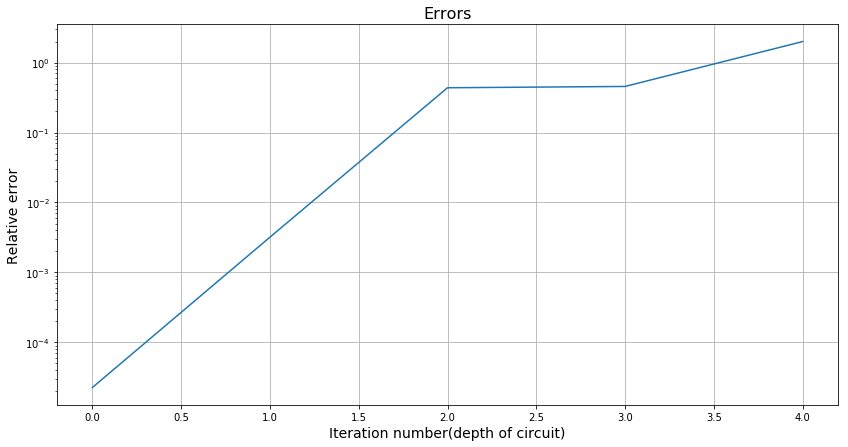

In [1031]:
import matplotlib.pyplot as plt
%matplotlib inline

errors = nand_error(iterations=5)
print(errors)

Text(0.5, 1.0, 'Errors for NAND gate (n=10, l=24, x=[0,1], m=5)')

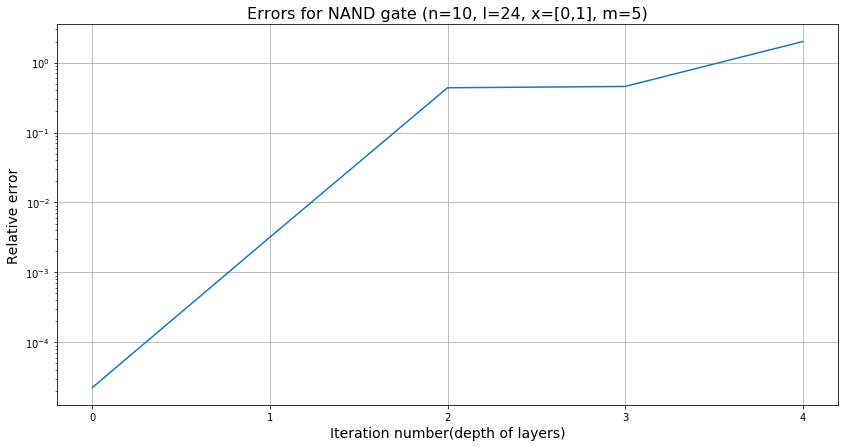

In [1039]:
from matplotlib.ticker import MaxNLocator

ax = plt.figure(figsize=(14, 7)).gca()
plt.xlabel("Iteration number(depth of layers)", size=14)
plt.ylabel("Relative error", size=14)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.semilogy(list(range(5)), errors)
plt.grid()
plt.title('Errors for NAND gate (n=10, l=24, x=[0,1], m=5)', size=16)

In [1055]:
def nand_error_2v(iterations):
    error = []
    fhe_local = GSW_FHE(n=10, q=2**24, l=25, x=(0, 2), m=5)
    t, v = fhe_local.SecretKeyGen()
    A = fhe_local.PublicKeyGen(t, v)
    def_val = fhe_local.Enc(A, 1)
    Cout = fhe_local.Enc(A, 0)
    xor_value = 1
    for i in range(iterations):
        print("Iteration number: ", i)
        xor_value = 1
        Cout = fhe_local.Flatten(np.eye(fhe_local.N).astype(int) + def_val @ Cout)
        x, vi = fhe_local.Dec(v, Cout)
        if (xor_value == 1):
            error.append(abs(vi - x)/abs(vi))
        else:
            error.append(abs(x)/abs(vi))
    return error

In [1056]:
errors_2v = nand_error_2v(iterations=5)
print(errors_2v)

m:  5
Error norm:  1.0
q/4:  4194304.0
Iteration number:  0
x, v[i]:  [8388859] [8388608]
Iteration number:  1
x, v[i]:  [33003] [8388608]
Iteration number:  2
x, v[i]:  [12545835] [8388608]
Iteration number:  3
x, v[i]:  [6213207] [8388608]
Iteration number:  4
x, v[i]:  [13621052] [8388608]
[array([2.99215317e-05]), array([0.99606574]), array([0.49558008]), array([0.25932801]), array([0.62375593])]


Text(0.5, 1.0, 'Errors for NAND gate (n=10, l=24, x=[0,1], m=5)')

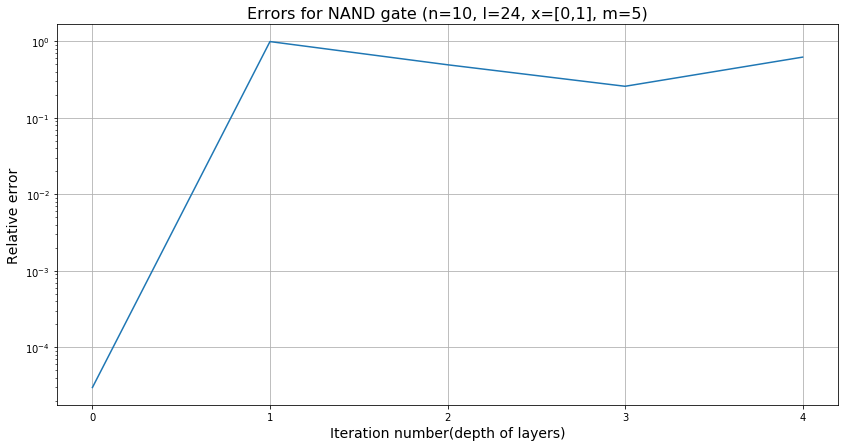

In [1057]:
ax = plt.figure(figsize=(14, 7)).gca()
plt.xlabel("Iteration number(depth of layers)", size=14)
plt.ylabel("Relative error", size=14)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.semilogy(list(range(5)), errors_2v)
plt.grid()
plt.title('Errors for NAND gate (n=10, l=24, x=[0,1], m=5)', size=16)